Final Project Notebook

In [2]:
# SETUP CODE
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [93]:
# Retrieving and preparing the dataset for classification

# Set the seed
set.seed(7134) 

# Read the dataset and discard the unnecessary columns
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip",temp)
bank_data <- read.table(unz(temp, "bank-additional/bank-additional-full.csv"), sep=";", header=TRUE) %>%
    select(age, job, marital, education, housing, loan, campaign, y)
unlink(temp)
bank_data <- as_tibble(bank_data)

# Filter out rows with unknown data
bank_data_filtered <- bank_data %>%
    filter(job != "unknown",
           marital != "unknown",
           education != "unknown",
           housing != "unknown",
           loan != "unknown")
             
# Convert all string columns to integers (needed for classification)
bank_data_nums <- bank_data_filtered %>%
    mutate(
        age = as.double(age),
        job = as.double(unclass(factor(job))), 
        marital = as.double(unclass(factor(marital))), 
        education = as.double(unclass(factor(education))), 
        housing = as.double(unclass(factor(housing))),
        loan = as.double(unclass(factor(loan))),
        y = factor(y)
    )
bank_data_nums

age,job,marital,education,housing,loan,campaign,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
56,4,2,1,1,1,1,no
57,8,2,4,1,1,1,no
37,8,2,4,2,1,1,no
40,1,2,2,1,1,1,no
56,8,2,4,1,2,1,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
73,6,2,6,2,1,1,yes
46,2,2,6,1,1,1,no
56,6,2,7,2,1,2,no


In [94]:
# Set the seed
set.seed(7134) 

# Split the dataset into training and testing sets
bank_split <- initial_split(bank_data_nums, prop = 0.75, strata = y)  
bank_train <- training(bank_split)   
bank_test <- testing(bank_split)
bank_test
bank_train

age,job,marital,education,housing,loan,campaign,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
40,1,2,2,1,1,1,no
56,8,2,4,1,2,1,no
57,4,1,1,2,1,1,no
55,6,3,4,2,1,1,no
39,7,2,3,1,1,1,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
32,1,2,7,1,1,1,yes
38,3,2,7,1,1,2,no
62,6,2,7,2,1,1,yes


age,job,marital,education,housing,loan,campaign,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
56,4,2,1,1,1,1,no
57,8,2,4,1,1,1,no
37,8,2,4,2,1,1,no
45,8,2,3,1,1,1,no
59,1,2,6,1,1,1,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,11,3,1,2,1,1,no
46,2,2,6,1,1,1,no
56,6,2,7,2,1,2,no


In [105]:
# Perform cross validation to determine the ideal # of neighbours

# Set the seed
set.seed(7134) 

# No need to use the entire dataset for this, 
# especially since cross validation would take too long on a datset so large
bank_sample <- rep_sample_n(bank_train, 1000)

bank_k_recipe <- recipe(y ~ age+job+education+housing+loan+marital+campaign, data = bank_sample) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

bank_vfold <- vfold_cv(bank_sample, v = 5, strata = y)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

bank_knn_results <- workflow() %>%
       add_recipe(bank_recipe) %>%
       add_model(knn_spec) %>%
       tune_grid(resamples = bank_vfold, grid = 20) %>%
       collect_metrics()
bank_knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8291115,5,0.013897622,Model01
1,roc_auc,binary,0.5231001,5,0.024025032,Model01
2,accuracy,binary,0.8291015,5,0.013191399,Model02
2,roc_auc,binary,0.5532386,5,0.028316448,Model02
3,accuracy,binary,0.8880277,5,0.005459024,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,roc_auc,binary,0.5280442,5,0.026406672,Model12
13,accuracy,binary,0.8960179,5,0.002733419,Model13
13,roc_auc,binary,0.5165229,5,0.030670480,Model13


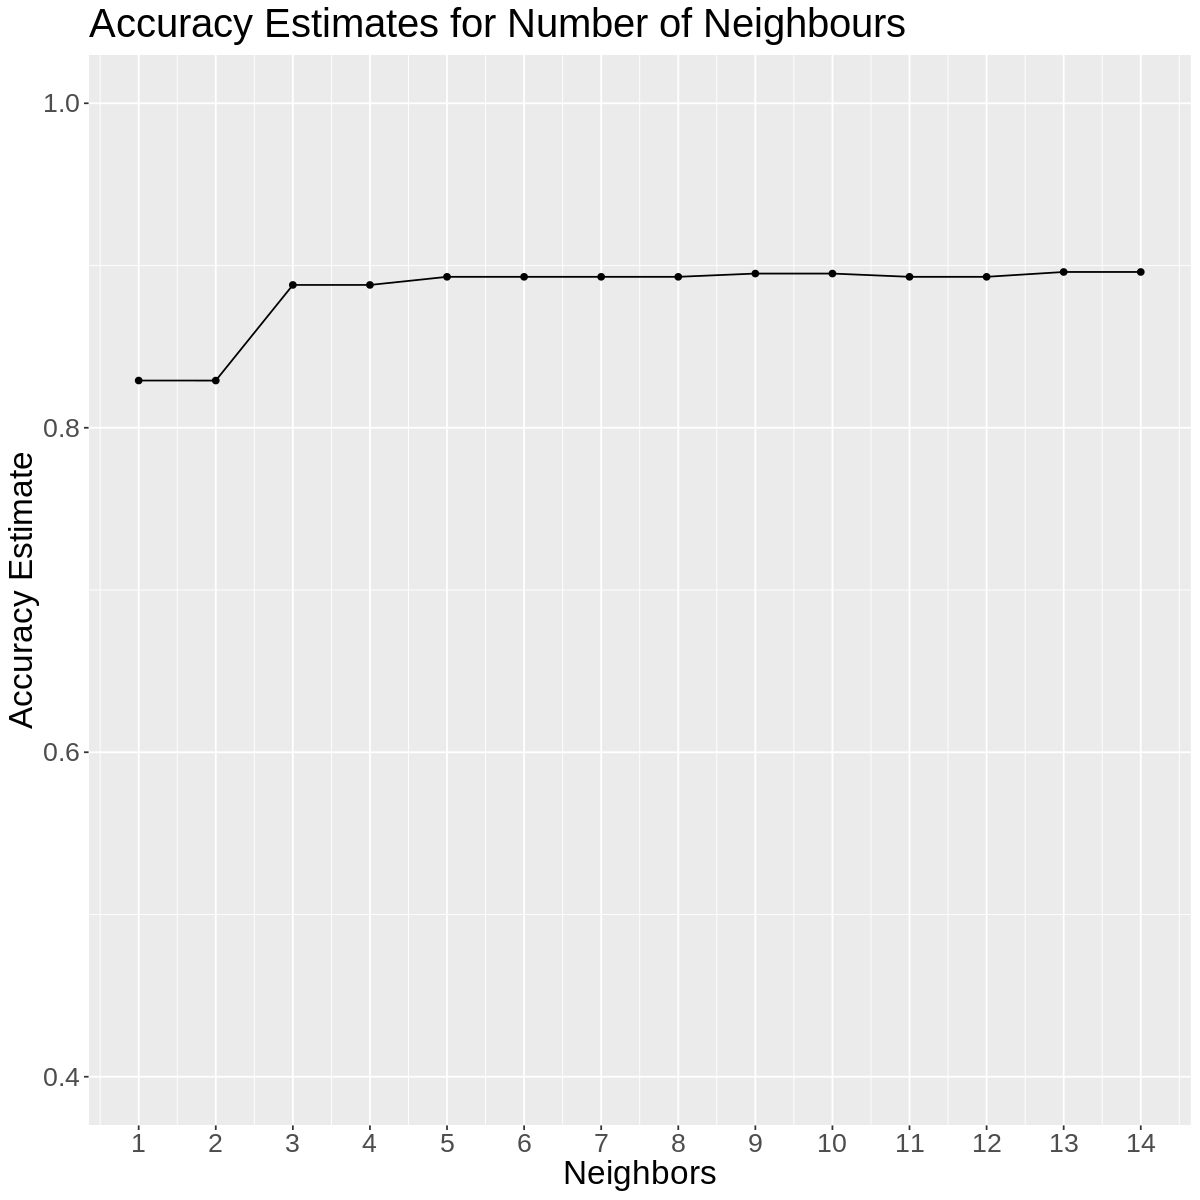

In [106]:
# Plot the accuracies of each k determined by cross validation
# to find the ideal value of k
options(repr.plot.width=10, repr.plot.height=10)

accuracies <- bank_knn_results %>% 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Accuracy Estimates for Number of Neighbours") +
       theme(text = element_text(size = 20)) +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis


# your code here
accuracy_versus_k

From the above plot, we can see that although having 9-14 neighbours would technically be the most accurate, the accuracy of any k greater than 2 is practically the same, therefore we will choose k = 3, since any k lower would be noticeably less accurate, and any k greater would be just as accurate, but require more computation time.

In [107]:
bank_recipe <- recipe(y ~ age+job+education+housing+loan+marital+campaign, data = bank_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

bank_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
       set_engine("kknn") %>%
       set_mode("classification")

bank_fit <- workflow() %>%
        add_recipe(bank_recipe) %>%
        add_model(bank_spec) %>%
        fit(data = bank_train)

In [92]:
bank_predictions <- predict(bank_fit , bank_test) %>%
       bind_cols(bank_test)
bank_predictions

bank_metrics <- bank_predictions %>%
         metrics(truth = y, estimate = .pred_class)
bank_metrics

bank_conf_mat <- bank_predictions %>% 
       conf_mat(truth = y, estimate = .pred_class)
bank_conf_mat

.pred_class,age,job,marital,education,housing,loan,campaign,y
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
no,40,1,2,2,1,1,1,no
no,56,8,2,4,1,2,1,no
no,57,4,1,1,2,1,1,no
no,55,6,3,4,2,1,1,no
no,39,7,2,3,1,1,1,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
no,32,1,2,7,1,1,1,yes
no,38,3,2,7,1,1,2,no
no,62,6,2,7,2,1,1,yes


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.88556485
kap,binary,0.05848182


          Truth
Prediction   no  yes
       no  8418 1016
       yes   78   48